Variables of filenames

Background comes from URQMD, signal from DCM, for test dataset for both bckgr and sign generated in urqmd

In [1]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/cbm/ML/JupyterNotebooks/'
signalFileName = directory + 'PlainTree_500kSign.root'
backgroundFileName = directory + 'PlainTree_6kBckgr_URQMD.root'
allFileName = directory + 'PlainTree_15kAll_URQMD.root'

In [2]:
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install

fatal: destination path 'CBM_ML_Lambda_Library' already exists and is not an empty directory.
/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
From https://github.com/shahidzk1/CBM_ML_Lambda_Library
 * branch            main       -> FETCH_HEAD
Already up to date.
running install
running bdist_egg
running egg_info
writing CBM_ML.egg-info/PKG

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from CBM_ML import tree_importer,  KFPF_lambda_cuts, plot_tools
from bayes_opt import BayesianOptimization

import gc, os

# Selecting Background and Signal
We generate PlainTrees from: 100k events (signal) and 20k evenents (background) with Au-Au @12A GeV/c, DCMQGSM-SMM generator passed through CBM setup in GEANT4, without any cuts

To omit imbalance classification problem (event though there are 5 times more events for background, the number of entries is much smaller for signal) we resample the data. We're deleting instances from the over-represented class (in our case the background) - it's called under-sampling, one of the resampling methods. 

So for training and testing we will get signal candidates from the 5 sigma region and  background from outside this region (3 times signal size).

In [4]:
#CUTS FOR MASS SELECTION
#5 sigma region for signal
lower5SigmaCutSign = 0.43485
upper5SigmaCutSign = 0.56135
#mean invariant mass
invMass = 0.4981
# "5sigma" (not acutal 5 sigma) region for background
lower5SigmaCutBckgr = 0.1
upper5SigmaCutBckgr = 2

In [5]:
# We import three root files into our jupyter notebook
#sign - before cleaning but after 5sigma seletion, signal - cleaned
#so that we dont have to reimport everything with each change
sign = tree_importer.tree_importer(signalFileName,'PlainTree',7)

# We only select lambda candidates in the 5 sigma region around the kaon mass peak
#we preserve the cleaned dataframe with a changed name
sign = sign[(sign['Candidates_generation']==1) & (sign['Candidates_mass']>lower5SigmaCutSign) & (sign['Candidates_mass']<upper5SigmaCutSign)]

# Similarly for the background, we select background candidates which are not in the 5 sigma region of the kaon peak
bckgr = tree_importer.tree_importer(backgroundFileName,'PlainTree',7)
#we preserve the cleaned dataframe with a changed name
bckgr = bckgr[(bckgr['Candidates_generation'] < 1)
                 & ((bckgr['Candidates_mass'] > lower5SigmaCutBckgr)
                 & (bckgr['Candidates_mass'] < lower5SigmaCutSign) | (bckgr['Candidates_mass']>upper5SigmaCutSign) 
                    & (bckgr['Candidates_mass'] < upper5SigmaCutBckgr))
             ].sample(n=3*(sign.shape[0])) #we select bckgr so that we have 4*more entries that for signal (before cleaning)

#Also call the garbage collector of python to collect unused items to free memory
gc.collect()

2506

In [6]:
#we remove name prefixes 'Candidates' and do some renaming
bckgr.columns = bckgr.columns.str.replace('Candidates_', '')
bckgr.columns = bckgr.columns.str.replace('_', '')
sign.columns = sign.columns.str.replace('Candidates_', '')
sign.columns = sign.columns.str.replace('_', '')
#we also get rid of coordinates errors
sign = sign.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr']).rename(columns={'generation' : 'issignal'})
bckgr = bckgr.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr']).rename(columns={'generation' : 'issignal'})
#let's check the name prefixes 
sign.iloc[0:10,:]

,chi2geo,chi2primfirst,chi2primsecond,chi2topo,cosinefirst,cosinesecond,cosinetopo,distance,eta,l,...,pT,phi,px,py,pz,rapidity,x,y,z,issignal
0,0.000002,2.789146e+00,3.414697e+02,0.152363,0.998430,0.978441,0.999726,0.038816,2.981088,0.603433,...,0.336420,2.886740,-0.325554,0.084812,3.306750,2.410393,-0.123734,-0.177956,0.600863,1.0
1,0.264513,1.474882e+06,1.260303e+06,1.848403,0.982548,0.976238,0.999997,0.001687,2.536047,18.872398,...,0.316806,-0.179362,0.311724,-0.056519,1.988028,1.928081,3.109412,-0.435314,18.628889,1.0
2,0.064274,3.623920e+06,1.747746e+06,0.256590,0.927869,0.975467,0.999997,0.003996,3.009254,4.463050,...,0.130762,0.559173,0.110846,0.069367,1.322198,1.682555,0.525349,0.317982,4.439318,1.0
3,0.022654,1.723264e+05,2.411727e+05,0.406959,0.986660,0.984264,1.000000,0.006170,7.433340,3.380137,...,0.002865,-2.576989,-0.002420,-0.001533,2.387398,2.273262,-0.056460,-0.080025,3.378509,1.0
4,1.538128,9.617859e+03,3.732512e+03,1.857859,0.905587,0.998455,0.999995,0.049966,3.027495,2.391879,...,0.159067,2.112874,-0.082065,0.136263,1.638160,1.867915,-0.172525,0.114815,2.379641,1.0
5,0.590288,1.296850e+06,1.223871e+06,2.634095,0.961413,0.957558,0.999978,0.006462,1.802818,3.241289,...,0.443765,2.740511,-0.408547,0.173252,1.309525,1.432320,-0.970163,0.154506,3.065898,1.0
6,0.721047,5.744036e+05,2.418638e+05,19.809374,0.974520,0.893650,0.999967,0.046300,2.350879,18.618280,...,0.229605,2.428807,-0.173706,0.150149,1.193890,1.508402,-2.550717,2.168915,18.284170,1.0
7,0.073615,1.446560e+05,1.016588e+05,0.687733,0.980289,0.996563,0.999999,0.045747,3.050026,24.100300,...,0.285753,2.216071,-0.171857,0.228298,3.010206,2.362526,-1.384464,1.550338,23.992416,1.0
8,0.744174,8.833737e+03,2.599425e+01,0.744472,0.999502,0.995903,0.999988,0.091523,3.268460,3.470731,...,0.556931,-2.060090,-0.261759,-0.491584,7.304965,2.969631,-0.121596,-0.344261,3.460147,1.0
9,6.557718,1.101657e+06,4.705889e+03,2.715420,0.938120,0.978224,0.999964,0.223624,3.030640,3.662582,...,0.139211,-2.587030,-0.118347,-0.073304,1.438195,1.752917,-0.272607,-0.259571,3.649118,1.0


The label 'issignal' tells us if an entry comes from signal (1) or background (0)

# Data Cleaning
Sometimes a data set contains entries which are outliers or does not make sense. For example, infinite values or NaN entries. We clean the data by removing these entries. 

Similarly, CBM is a fixed target experiment so there are certain conditions which the data has to satisfy before it is considered as reliable data.So we apply certain limits on the data sets.

The values of these cuts are described: https://drive.google.com/file/d/1tb0FBRq4KgVu-VQZgpjA8ONbIGVCNOnE/view?usp=sharing https://github.com/julnow/JupyterNotebooks/blob/kaon/CBM%20K-short%20data%20cleaning.pdf

In [7]:
#CUTS USED FOR DATA CLEANING
#mass cuts for both bckgr and sign
lowerMassCut = 0.279
upperMassCut = 1.5
#distance cuts
#DCA
lowerDcaCut = 0
upperDcaCut = 100
#l distance
lowerLCut = -5
upperLCut = 80
#loverdl
lowerLdlCut = -25
upperLdlCut = 15000
#coordinate cuts
absXCut = 50
absYCut = 50
lowerZCut = -1
upperZCut = 80
#momentums cuts
pzLowerCut = 0
pUpperCut = 20
ptUpperCut = 3
#chi2
#geo
lowerChi2GeoCut = 0
upperChi2GeoCut = 10000
#topo
lowerChi2TopoCut = 0
upperChi2TopoCut = 100000
#prim first
lowerChi2PrimFirstCut = 0
upperChi2PrimFirstCut = 3e7
#prim second
lowerChi2PrimSecondCut = 0
upperChi2PrimSecondCut = 3e7
#pseudorapidity cuts
lowerEtaCut = 1.
upperEtaCut = 6.5

In [8]:
def clean_df(df):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    is_good_mom = (df['pz'] > pzLowerCut) & (df['p']<pUpperCut) & (df['pT']<ptUpperCut)
    is_good_coord = (abs(df['x']) < absXCut) & (abs(df['y']) < absYCut) & (df['z']>lowerZCut) & (df['z']<upperZCut)
    is_good_params = (df['distance'] > lowerDcaCut) & (df['distance'] < upperDcaCut) & (df['chi2geo']>lowerChi2GeoCut) & (df['chi2geo'] < upperChi2GeoCut) & (df['chi2topo'] > lowerChi2TopoCut) & (df['chi2topo'] < upperChi2TopoCut) & (df['eta']>lowerEtaCut) & (df['eta']<upperEtaCut)& (df['l']>lowerLCut) & (df['l']<upperLCut) & (df['loverdl']>lowerLdlCut) & (df['loverdl']<upperLdlCut)
    is_good_daughters = (df['chi2primfirst']>lowerChi2PrimFirstCut) & (df['chi2primfirst'] < upperChi2PrimSecondCut) & (df['chi2primsecond']>lowerChi2PrimSecondCut) & (df['chi2primsecond']<upperChi2PrimFirstCut)
    is_good_mass = (df['mass']>lowerMassCut) & (df['mass']<upperMassCut)

    is_good_df = (is_good_mom) & (is_good_coord) & (is_good_params) & (is_good_daughters) & (is_good_mass)

    return df[is_good_df]

In [9]:
background = clean_df(bckgr)
signal = clean_df(sign)
del sign, bckgr

We'll also import and clean dataset of 10k events for both background and signal (for testing our algorhitm)

In [10]:
df_origin = tree_importer.tree_importer(allFileName,'PlainTree',7)
df_origin.columns = df_origin.columns.str.replace('Candidates_', '')
df_origin.columns = df_origin.columns.str.replace('_', '')
df_origin = df_origin.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr']).rename(columns={'generation' : 'issignal'})
df_clean = clean_df(df_origin)
del df_origin
#lets shuffle data
df_clean= df_clean.sample(frac=1)
gc.collect()
#lets look at impoted tree
df_clean.iloc[0:10,:]

,chi2geo,chi2primfirst,chi2primsecond,chi2topo,cosinefirst,cosinesecond,cosinetopo,distance,eta,l,...,pT,phi,px,py,pz,rapidity,x,y,z,issignal
14459504,1.264158,3.277953,0.228559,1.121456,0.994622,0.995349,0.925101,0.002592,3.066017,0.004095,...,0.492509,-2.843128,-0.470735,-0.144824,5.272202,2.613702,0.180653,0.071397,0.003944,0.0
31264663,0.847028,5.515515,1.450845,0.839599,0.971961,0.977486,-0.990657,0.007474,2.984328,-0.037388,...,0.126636,-3.035788,-0.125927,-0.013374,1.248792,1.809983,-0.119546,-0.021129,-0.035836,0.0
19024194,0.027511,0.893639,0.785334,0.158994,0.999738,0.999970,0.999973,0.000622,2.126495,0.139465,...,0.877592,0.866790,0.568045,0.668949,3.627162,2.064146,-0.010330,0.000917,0.134305,0.0
23688658,0.537085,0.189104,5.414111,1.844918,0.991562,0.994463,0.592375,0.002041,2.713132,0.001938,...,0.848582,-0.590872,0.704710,-0.472733,6.368647,2.395807,0.017355,0.090481,0.002577,0.0
24529621,0.309280,5.082135,4.227371,1.753493,0.947055,0.940179,0.940510,0.084664,3.143892,0.374181,...,0.131043,-0.397272,0.120837,-0.050701,1.516891,1.632539,-0.063963,0.180059,0.383360,0.0
12588282,14.447187,4.321352,54.246624,18.817444,0.923538,0.947760,-0.403920,0.035527,3.644852,-0.006366,...,0.143012,-2.086800,-0.070563,-0.124391,2.735198,1.667138,0.001217,0.018220,-0.008494,0.0
18079446,0.082987,0.085631,0.114023,0.036455,0.999806,0.948391,0.999686,0.003951,2.813947,0.007124,...,0.754572,1.486425,0.063589,0.751888,6.268836,2.457800,0.062578,-0.049390,0.007060,0.0
8653770,29.084797,1643.676758,1.035707,23.176935,0.978938,0.959792,-0.963520,0.271475,2.121946,-0.500003,...,0.125550,2.416517,-0.093968,0.083264,0.516484,1.217968,0.221470,-0.033734,-0.496238,0.0
323957,178.040009,3.136331,4427.193359,120.175270,0.999168,0.972414,0.998947,0.120895,3.638049,0.627802,...,0.132272,1.664008,-0.012311,0.131697,2.512602,2.362830,-0.049328,0.012367,0.627159,0.0
24268717,3904.955811,0.648547,42161.476562,102.010338,0.993683,0.765763,0.988867,3.783568,3.013838,4.042659,...,0.295099,-2.065571,-0.140123,-0.259709,2.997644,1.730901,-0.897178,-0.450350,3.998976,0.0


In [11]:
#Let's combine signal and background
df_scaled = pd.concat([signal, background])
# Let's shuffle the rows randomly
df_scaled = df_scaled.sample(frac=1)

In [12]:
print('size of:\nsignal: ' + str(len(signal)) + '\nbackground: ' + str(len(background)) 
      + '\nbackground to signal ratio: ' + str(round(len(background)/len(signal), 1))  
      + '\ntest set (both signal and background): ' + str(len(df_clean))
      + '\ntest set (background to signal ratio): ' 
      + str(round(len(df_clean.loc[df_clean['issignal'] == 0])/len(df_clean.loc[df_clean['issignal'] == 1]), 1)))

size of:
signal: 450442
background: 1228115
background to signal ratio: 2.7
test set (both signal and background): 28740227
test set (background to signal ratio): 1985.1


# Selecting Background and Signal
After cleaning, our training data set contains 238477 background candidates and 89987 signal candidates (background to signal ratio $\approx 2.7$). For testing, we'll use cleaned dataset containing 34200168 entries of signal and background (background to signal ratio $\approx 1871.3$)

Here, we use under-sampling to tackle the problem with the classification of underrepresented class (normally, the signal is only approx. 0.05% of real data)

In [13]:
if not os.path.exists(directory+'img/xgb2'):
    os.makedirs(directory+'img/xgb2')
#lets draw sign to background ratio
def plt_sig_back(df):
    range1 = (lowerMassCut, upperMassCut)
    fig, axs = plt.subplots(figsize=(20, 10))
    #df_scaled['mass'].plot.hist(bins = 300, range=range1,grid=True,sharey=True)
    (df[df['issignal']==0])['mass'].plot.hist(bins = 300, facecolor='yellow',grid=True,range=range1, label='Background')
    (df[df['issignal']==1])['mass'].plot.hist(bins = 300, facecolor='magenta',grid=True, range=range1, label ='Signal')
    #plt.vlines(x=1.108,ymin=-1,ymax=48000, color='black', linestyle='-')
    #plt.vlines(x=1.1227,ymin=-1,ymax=48000, color='black', linestyle='-')
    plt.ylabel("Counts (log scale)", fontsize=15)
    plt.xlabel("Mass in GeV/$c^2$", fontsize= 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Test and Train K-short Invariant Mass', fontsize = 15)
    plt.legend( fontsize = 15)
    axs.tick_params(axis='both', which='major', labelsize=18)
    plt.yscale("log")
    fig.tight_layout()
    fig.savefig(directory+'img/xgb2/inv_mass_trainset.pdf')
    fig.savefig(directory+'img/xgb2/inv_mass_trainset.png')

0

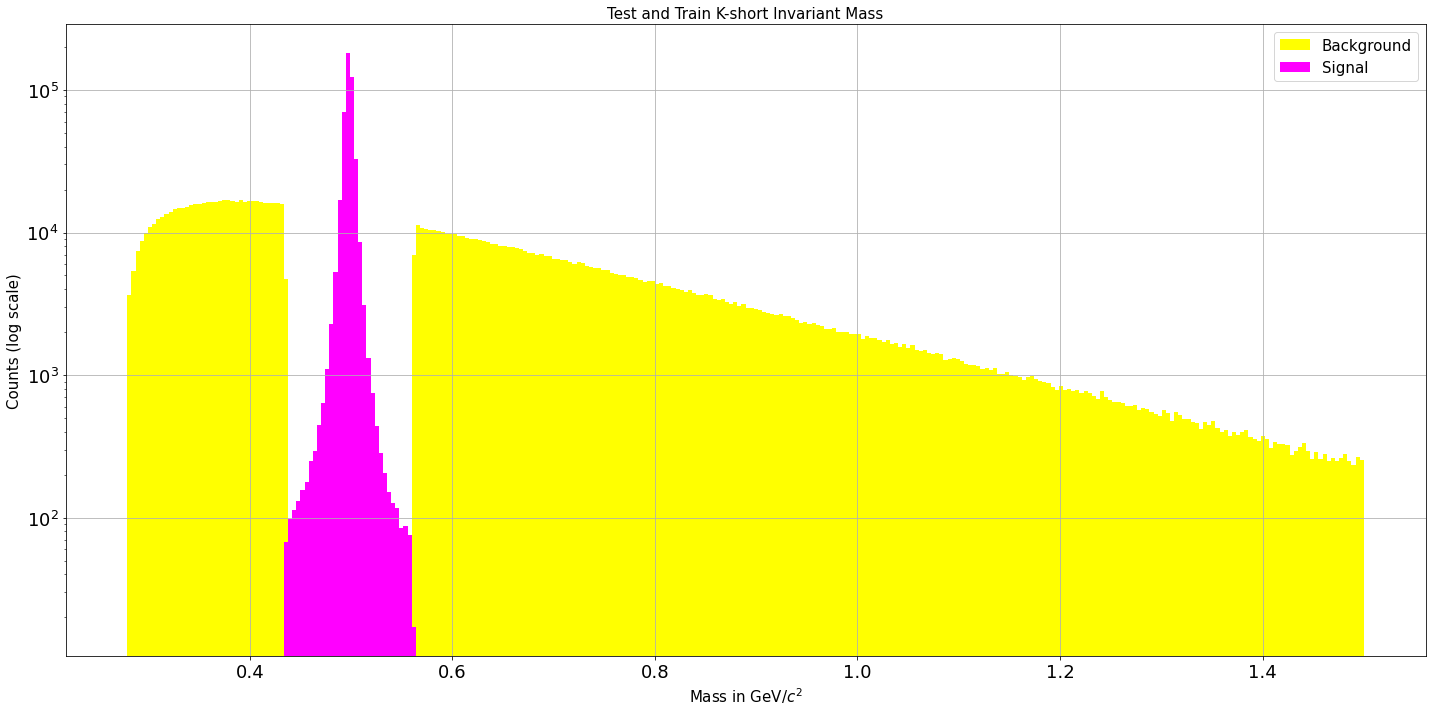

In [14]:
plt_sig_back(df_scaled)
gc.collect()

# Creating Train and Test sets
To make machine learning algorithms more efficient on unseen data we divide our data into two sets. One set is for training the algorithm and the other is for testing the algorithm. If we don't do this then the algorithm can overfit and we will not capture the general trends in the data. 

In [15]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
cuts = [ 'loverdl', 'distance', 'chi2geo', 'chi2topo', 'chi2primfirst', 'chi2primsecond']


x = df_scaled[cuts].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(df_scaled['issignal'], dtype='int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=324)

#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest=xgb.DMatrix(x_test, label = y_test)

## Whole set
We also select the selected variables from the 10k events data set

In [16]:
x_whole = df_clean[cuts].copy()
y_whole = pd.DataFrame(df_clean['issignal'], dtype='int')

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>XGB Boost 
<br></p><br>

In [17]:
#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_whole, label = y_whole)
dtest1=xgb.DMatrix(x_test, label = y_test)

## Bayesian optimization
In order to find the best parameters of XGB for our data we use Bayesian optimization. Grid search and and random search could also do the same job but bayesian is more time efficient. For further reading visit [the git page](https://github.com/fmfn/BayesianOptimization) of the bayesian optimization used here.

### Hyper parameters
Some of the following hyper parameters will be tuned for our algorithm:


*subsample* [default=1]
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
range: (0,1]

*eta* [default=0.3, alias: learning_rate]
Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
range: [0,1]


*gamma* [default=0, alias: min_split_loss]
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
range: [0,∞]


*alpha* [default=0, alias: reg_alpha]
L1 regularization term on weights. Increasing this value will make model more conservative.

*Lasso Regression* (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [18]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, alpha, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'auc', 'nthread' : 7}
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    return  cv_result['test-auc-mean'].iloc[-1]



In [19]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'gamma': (0, 1),
                                            'alpha': (2,20),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,500)
                                            })

In [20]:
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5)

|   iter    |  target   |   alpha   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
[16:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 46 pruned nodes, max_depth=8
[16:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 48 pruned nodes, max_depth=8
[16:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 38 pruned nodes, max_depth=8
[16:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 38 pruned nodes, max_depth=8
[16:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 58 pruned nodes, max_depth=8
[16:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 46 pruned nodes, max_depth=8
[16:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 58 pruned nodes, max_depth=8
[16:27:59] src/tree/updater_pr

In [21]:
# best target so far 0.9974727999999999
print(xgb_bo.max)

{'target': 0.9974727999999999, 'params': {'alpha': 7.943341808918682, 'gamma': 0.5909167040062935, 'learning_rate': 0.07739229108278967, 'max_depth': 9.55601021621136, 'n_estimators': 375.47181785090754}}


# XGB models
Now let's take the parameters selected by the bayesian optimization and apply them in our training and testing. 

In [22]:
max_param = xgb_bo.max['params']
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'], 'max_depth': int(round(max_param['max_depth'],0)), 'n_estimators': int(round(max_param['n_estimators'],0)), 'objective': 'reg:logistic'}

In [23]:
#To train the algorithm using the parameters selected by bayesian optimization
bst = xgb.train(param, dtrain)

[17:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 48 pruned nodes, max_depth=10
[17:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 54 pruned nodes, max_depth=10
[17:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 38 pruned nodes, max_depth=10
[17:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 44 pruned nodes, max_depth=10
[17:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 66 pruned nodes, max_depth=10
[17:10:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 40 pruned nodes, max_depth=10
[17:10:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 36 pruned nodes, max_depth=10
[17:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 50 pruned nodes, max_depth=10
[17:10:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra no

In [24]:
#We apply our model on the training data that was trained on the training data, this helps us to control overfitting
bst1= bst.predict(dtrain)

In [25]:
# We apply our trained model on test data and store the predictions in a bst_test dataframe
bst_test = pd.DataFrame(data=bst.predict(dtest1),  columns=["xgb_preds"])
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
# We also store the MC information in this dataFrame
bst_test['issignal']=y_test['issignal']

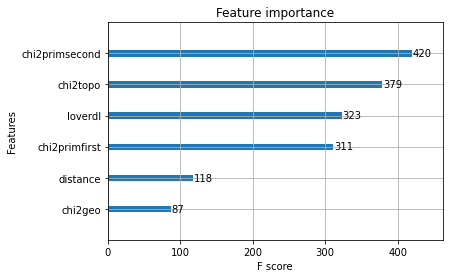

In [26]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
ax.figure.savefig(directory+'img/xgb2/feature_importance.pdf')
ax.figure.savefig(directory+'img/xgb2/feature_importance.png')

## AUC and ROC

The function roc_curve computes the receiver operating characteristic curve, or ROC curve. Quoting Wikipedia :

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

This function requires the true binary value and the target scores, which can either be probability estimates of the positive class, confidence values, or binary decisions.

Similarly, the function roc_auc_score computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

To find the best threshold which results more signal to background ratio for lambda candidates we use the parameter S0 called the approximate median significance by the higgs boson  ML challenge (http://higgsml.lal.in2p3.fr/documentation,9.)

In [27]:
def AMS(y_true, y_predict, y_true1, y_predict1):
    roc_auc=roc_auc_score(y_true, y_predict)
    fpr, tpr, thresholds = roc_curve(y_true, y_predict,drop_intermediate=False ,pos_label=1)
    S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
    S0 = S0[~np.isnan(S0)]
    xi = argmax(S0)
    S0_best_threshold = (thresholds[xi])

    roc_auc1=roc_auc_score(y_true1, y_predict1)
    fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_predict1,drop_intermediate=False ,pos_label=1)
    S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))
    S01 = S01[~np.isnan(S01)]
    xi1 = argmax(S01)
    S0_best_threshold1 = (thresholds[xi1])

    #plotting
    fig, axs = plt.subplots(figsize=(15, 10), dpi = 100)
    plt.plot(fpr, tpr, linestyle=':',color='darkorange',label='ROC curve train (area = %0.4f)' % roc_auc)
    plt.plot(fpr1, tpr1, color='green',label='ROC curve test (area = %0.4f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.scatter(fpr[xi], tpr[xi], marker='o', color='black', label= 'Best Threshold train set = '+"%.4f" % S0_best_threshold +'\n S0 = '+ "%.2f" % S0[xi])
    plt.scatter(fpr1[xi1], tpr1[xi1], marker='o', color='blue', label= 'Best Threshold test set = '+"%.4f" % S0_best_threshold1 +'\n S0 = '+ "%.2f" % S01[xi1])
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.legend(loc="lower right", fontsize = 15)
    plt.title('Receiver operating characteristic', fontsize = 15)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.02])
    
    fig.tight_layout()
    plt.show()
    fig.savefig(directory+'img/xgb2/ams.pdf')
    fig.savefig(directory+'img/xgb2/ams.png')

    return S0_best_threshold, S0_best_threshold1

/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_6291/281991432.py:4: RuntimeWarning: invalid value encountered in true_divide
  S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/ipykernel_6291/281991432.py:11: RuntimeWarning: invalid value encountered in true_divide
  S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))


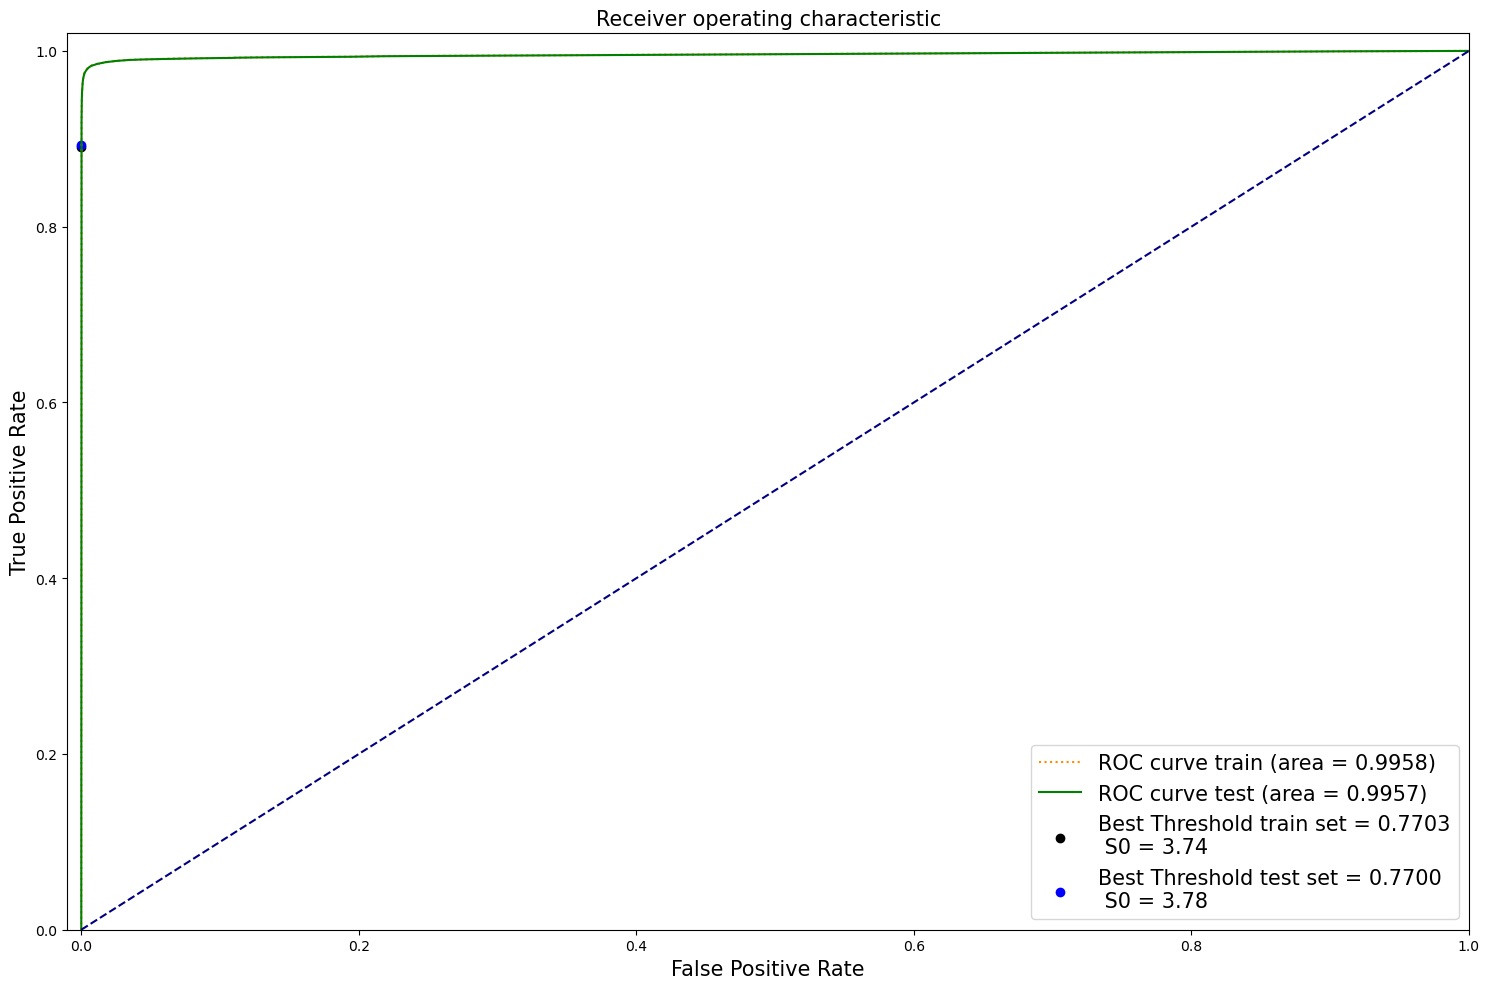

In [28]:
train_best, test_best = AMS(y_train, bst1, y_test, bst_test['xgb_preds'])

When the AUC, best threshold and approximate median significance for train and test are nearly the same, we save that model and use it. This means that our model is general enough. In my opinion, if the test S0 is above 3.0 then it is a good enough model.

## Applying the model on the 10k events data-set

In [29]:
df_clean['xgb_preds'] = bst.predict(dtest)

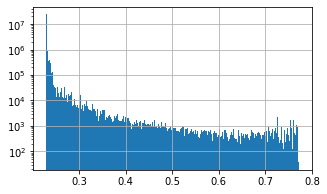

In [30]:
df_clean['xgb_preds'].hist(bins=300)
plt.yscale('log')

## Confusion Matrix

A **Confusion Matrix** $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true positives is $C_{00}$, false negatives $C_{01}$,false positives is $C_{10}$, and true neagtives is $C_{11}$.

If $ y^{'}_{i} $ is the predicted value of the $ i$-th sample and $y_{i}$ is the corresponding true value, then the fraction of correct predictions over $ n_{samples}$ is defined as 
$$
True \: positives (y,y^{'}) =  \sum_{i=1}^{n_{samples} } 1 (y^{'}_{i} = y_{i}=1)
$$ 

The following function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

In [33]:
#calculate efficency and false tu tru signal ratio
def confustion_stats(df, cm):
    all_signals = len(df.loc[df['issignal'] == 1])
    true_signal = cm[0][0]
    false_signal = cm[1][0]        
    reconstructed_signals = true_signal + false_signal
    false_to_true_signals = false_signal / true_signal
    efficiency = reconstructed_signals / all_signals * 100 #efficency in % for all
    efficiency_true = true_signal / all_signals * 100 #efficency in % for all
    print("Efficiency: " + str(round(efficiency, 2)) + "%")
    print("Efficiency of true signal candidates reconstruction: " + str(round(efficiency_true, 2)) + "%")
    print("False tu true reconstructed signal ratio: " + str(round(false_to_true_signals, 2)))

Confusion matrix, without normalization
[[   12952     1519]
 [    3947 28721770]]


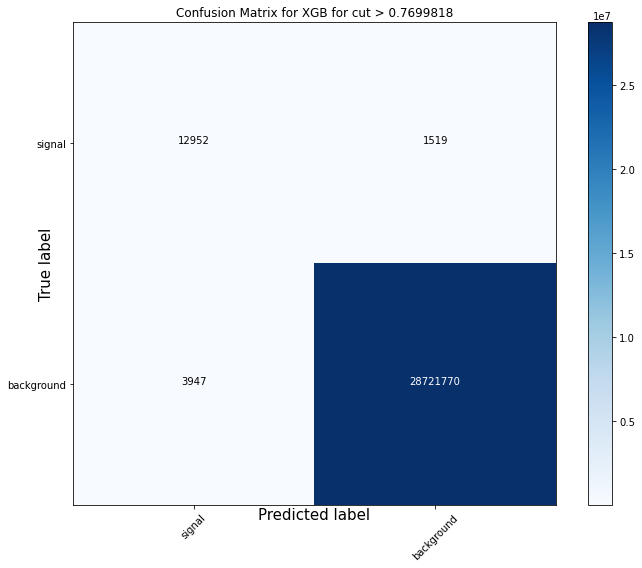

In [34]:
#lets take the best threshold and look at the confusion matrix
cut1 = test_best
df_clean['xgb_preds1'] = ((df_clean['xgb_preds']>cut1)*1)
cnf_matrix = confusion_matrix(y_whole, df_clean['xgb_preds1'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=['signal','background'], title='Confusion Matrix for XGB for cut > '+str(cut1))
fig.savefig(directory+'img/xgb2/confusion_matrix_extreme_gradient_boosting_whole_data.pdf')
fig.savefig(directory+'img/xgb2/confusion_matrix_extreme_gradient_boosting_whole_data.png')

In [35]:
confustion_stats(df_clean, cnf_matrix)

Efficiency: 116.78%
Efficiency of true signal candidates reconstruction: 89.5%
False tu true reconstructed signal ratio: 0.3


In [36]:
# The following function will display the inavriant mass histogram of the original 10k event set along with the mass histoigram after we apply a cut
# on the probability prediction of xgb
def cut_visualization(cut, range1=(lowerMassCut, upperMassCut), bins1= 300 ):
    mask1 = df_clean['xgb_preds']>cut
    df3=df_clean[mask1]
    
    fig, ax2 = plt.subplots(figsize=(15, 10), dpi = 200)
    color = 'tab:blue'
    ax2.hist(df_clean['mass'],bins = bins1, range=range1, facecolor='blue',alpha = 0.35, label='before selection')
    ax2.set_ylabel('Counts', fontsize = 15, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend( fontsize = 15, loc='upper left')
    
    color = 'tab:red'
    ax1 = ax2.twinx()
    ax1.hist(df3['mass'], bins = bins1, range=range1, facecolor='red',alpha = 0.35, label='XGB')
    ax1.set_xlabel('Mass in GeV', fontsize = 15)
    ax1.set_ylabel('Counts ', fontsize = 15, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend( fontsize = 15,loc='upper right' )

    plt.title("The original sample's Invariant Mass along with mass after selection of XGB (with a cut > "+str(cut)+')', fontsize = 15)
    fig.tight_layout()
    fig.savefig(directory+'img/xgb2/whole_sample_invmass_with_ML.pdf')
    fig.savefig(directory+'img/xgb2/whole_sample_invmass_with_ML.png')

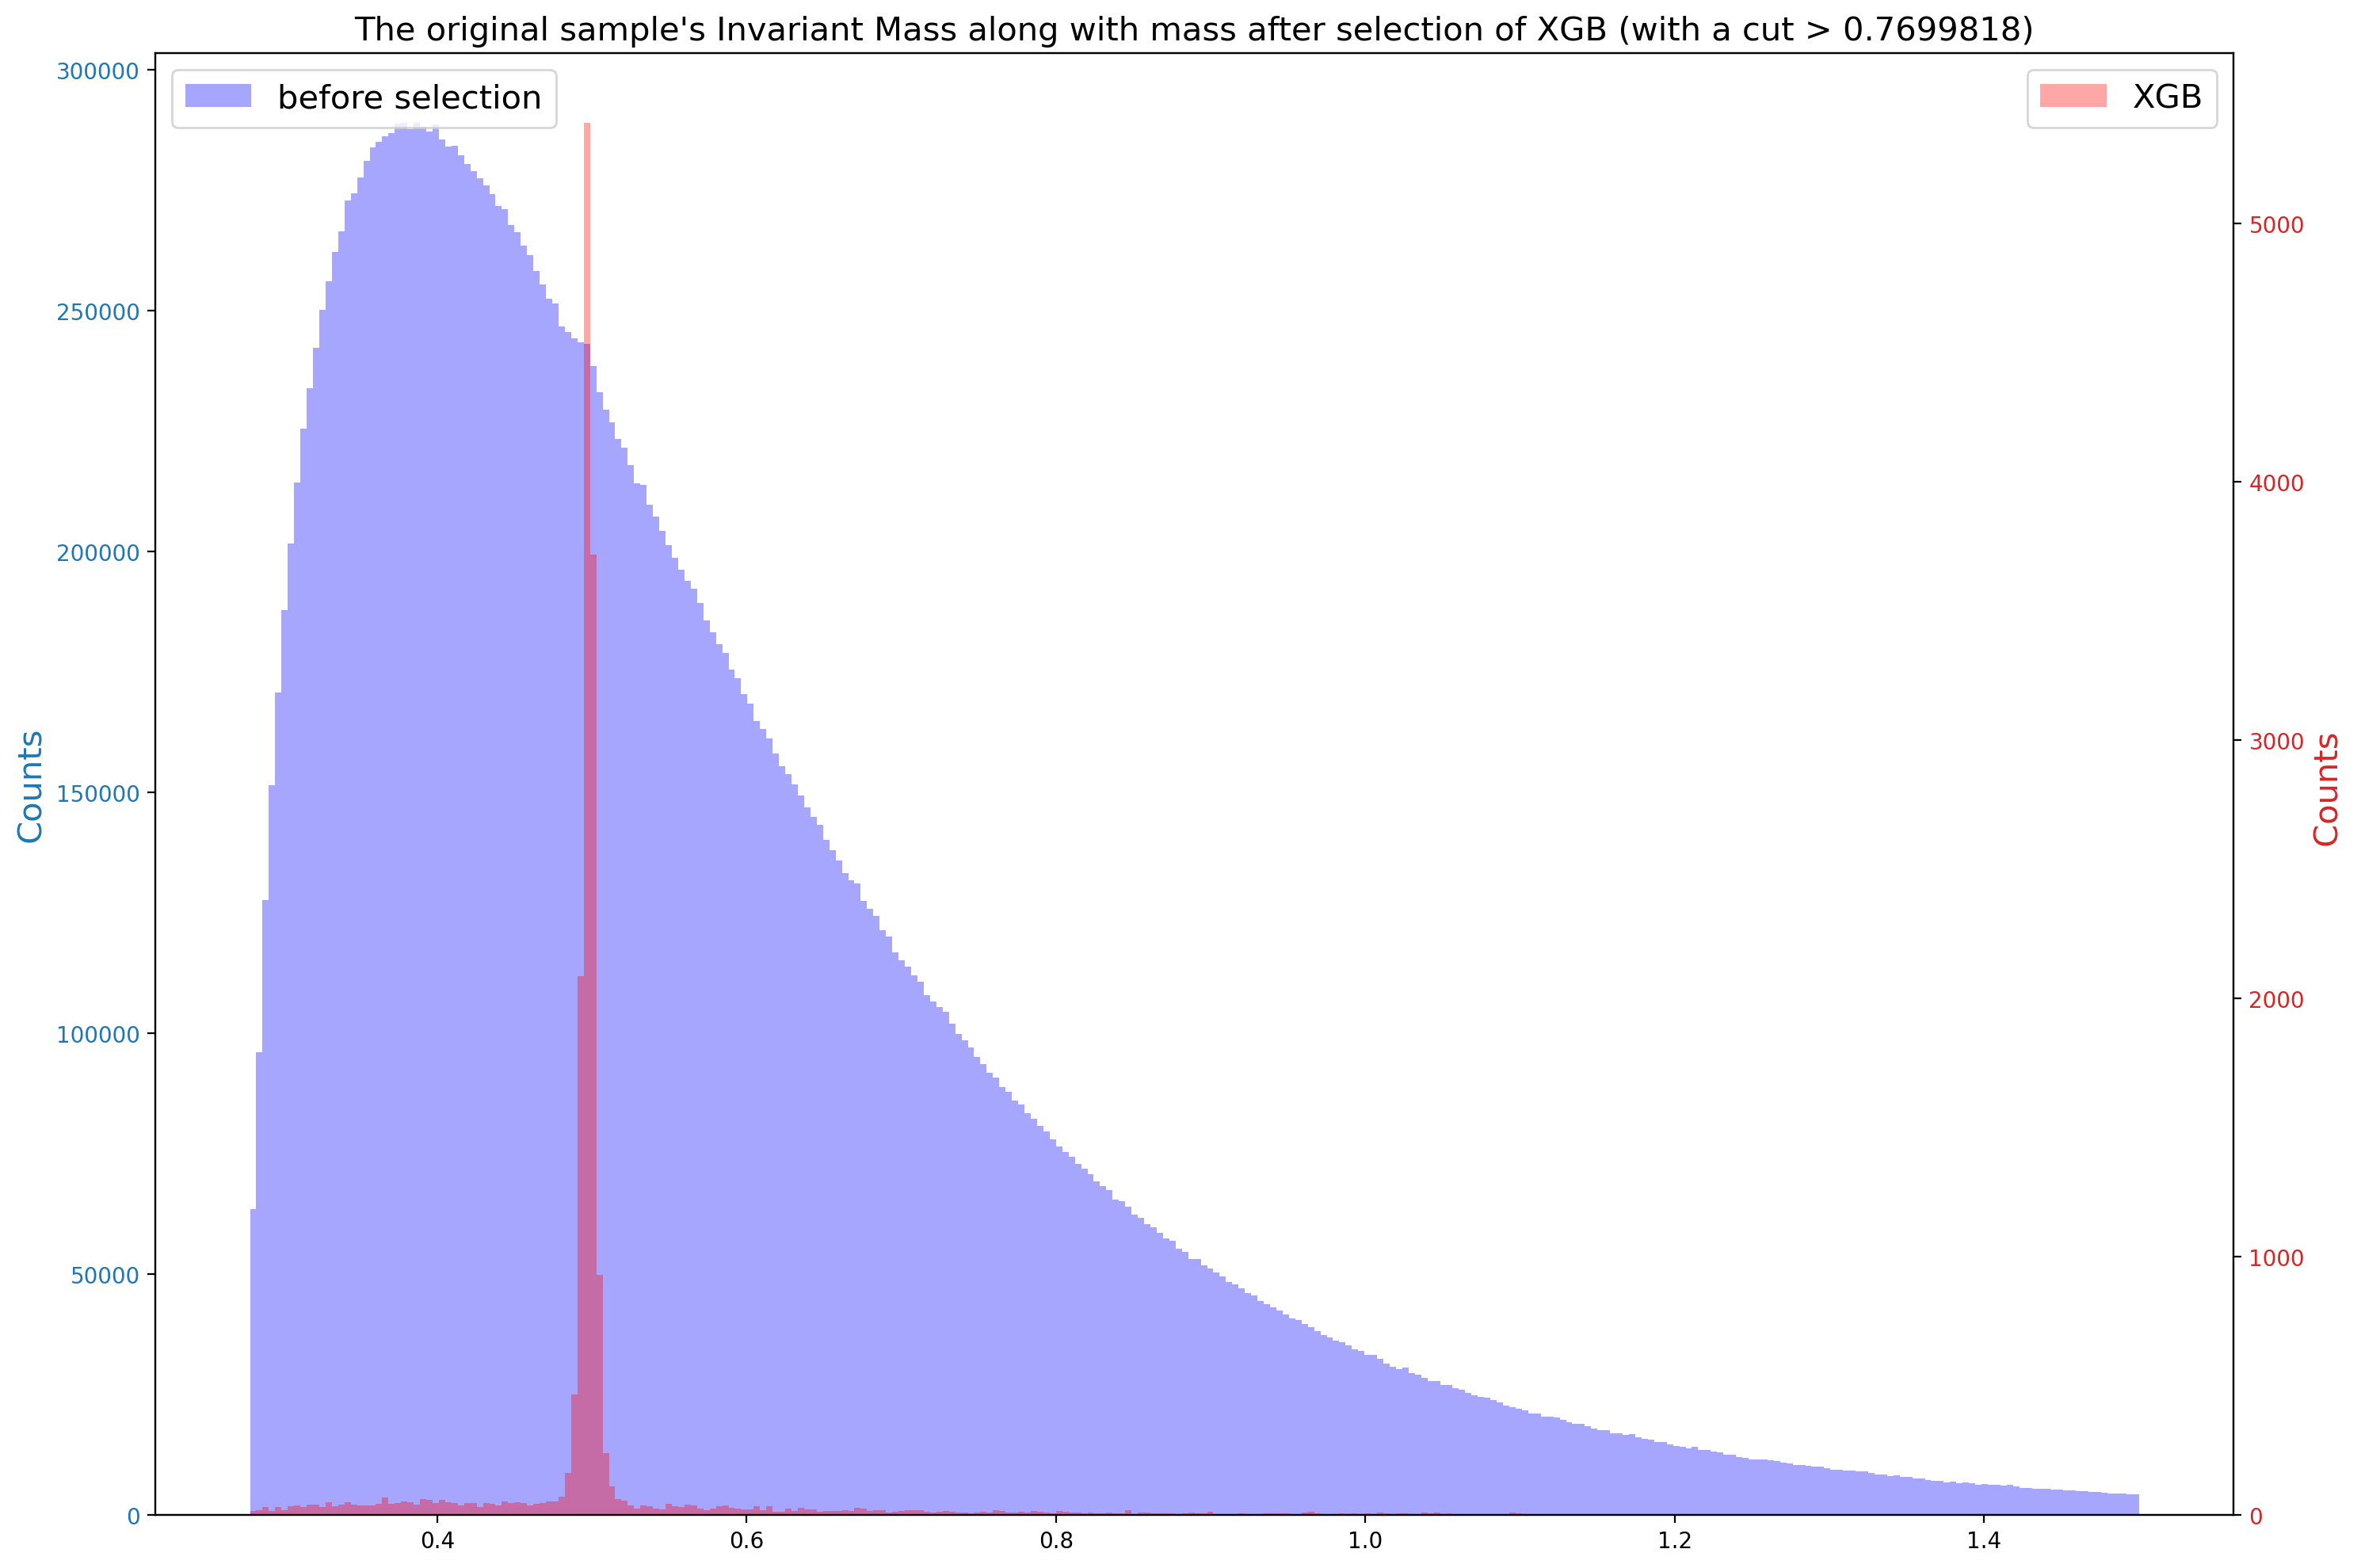

In [37]:
cut_visualization(test_best)

# Comparison with the manually optimized cuts of KFPF
In the already existing Kalman Filter Particle Finder (KFPF) package for online reconstruction and selection of short-lived particles in CBM, these criteria have been manually optimized. These selection-cuts have been selected to maximize the signal to background ratio (S/B) of the $\Lambda$ for a certain energy on a collisions generator. The selection criteria mainly depends on the collision energy, decay channel and detector configuration.

In [38]:
#manually selected cuts
manCut_loverdl = 30
manCut_dca = 0.4
manCut_chi2topo = 20
manCut_chi2geo = 12

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Confusion matrix, without normalization
[[11112     0]
 [ 4502     0]]


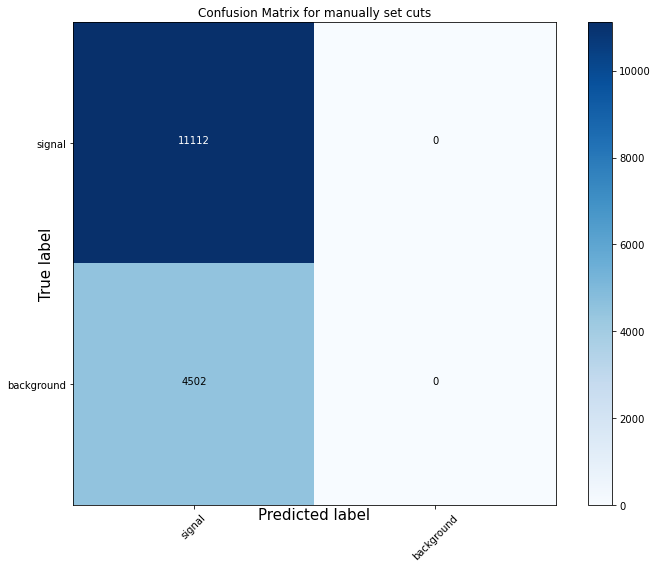

In [40]:
new_check_set= df_clean.copy()
new_check_set['new_signal']=0

mask1 = (new_check_set['loverdl'] > manCut_loverdl) & (new_check_set['distance'] < manCut_dca)

mask2 = (new_check_set['chi2topo'] < manCut_chi2topo) & (new_check_set['chi2geo'] < manCut_chi2geo) 

new_check_set = new_check_set[(mask1) & (mask2)] 

#After all these cuts, what is left is considered as signal, so we replace all the values in the 'new_signal'
# column by 1
new_check_set['new_signal'] = 1
cnf_matrix1 = confusion_matrix(new_check_set['issignal'], new_check_set['new_signal'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix1, classes=['signal','background'], title='Confusion Matrix for manually set cuts')
fig.savefig(directory+'img/xgb2/confusion_matrix_for_manually_set_cuts.pdf')
fig.savefig(directory+'img/xgb2/confusion_matrix_for_manually_set_cuts.png')

In [41]:
confustion_stats(df_clean, cnf_matrix1)

Efficiency: 107.9%
Efficiency of true signal candidates reconstruction: 76.79%
False tu true reconstructed signal ratio: 0.41


In [42]:
cut3 = test_best
mask1 = df_clean['xgb_preds']>cut3
df3=df_clean[mask1]

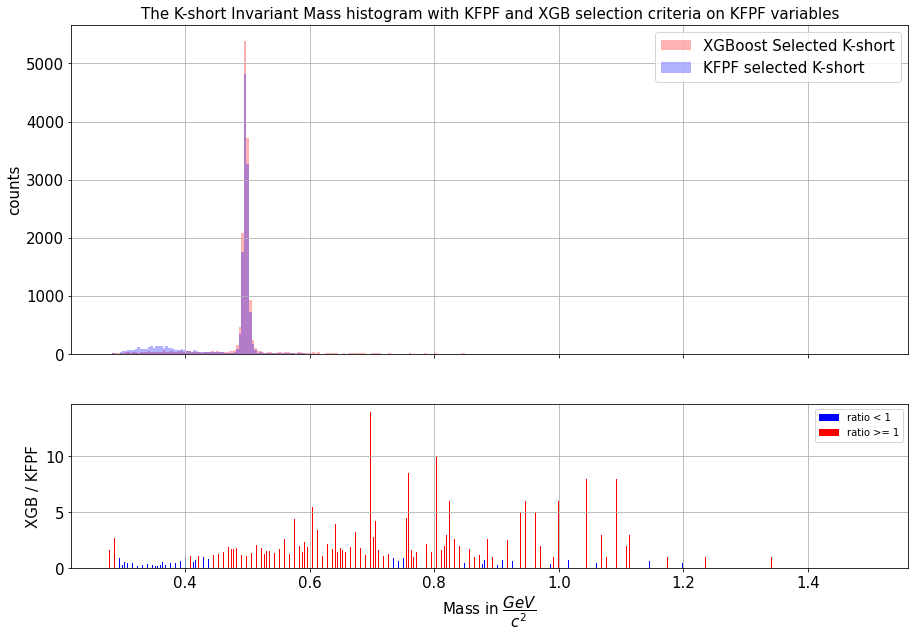

In [43]:
from matplotlib import gridspec

range1= (lowerMassCut, upperMassCut)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3['mass']),bins = 300, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 300, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGBoost Selected K-short','KFPF selected K-short'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The K-short Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3['mass'],range=(lowerMassCut, upperMassCut), bins=300)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(lowerMassCut, upperMassCut), bins=300)

#ratio checked with division by 0
ratioBlue = [] #ratio smaller than 1
ratioRed = [] # ratio bigger than 1
for i in range(len(ns1)):
    if (ns1[i] != 0):
        ratio = ns[i] / ns1[i]
        if (ratio < 1):
            ratioBlue.append(ratio)
            ratioRed.append(0)
        else:
            ratioBlue.append(0)
            ratioRed.append(ratio)
    else:
        ratioBlue.append(0)
        ratioRed.append(0)
#col = []
# for val in ratio:
#     if val < 1:
#         col.append('blue')
#     else:
#         col.append('red')        
axs[1].bar(bins[:-1],     
        ratioBlue, 
        width=0.001,
        color = 'blue',
        label='ratio < 1')
axs[1].bar(bins[:-1],     
        ratioRed, 
        width=0.001,
        color = 'red',
        label='ratio >= 1')
axs[1].legend( loc='upper right')
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/xgb2/kaon_inv_mass_comparison.png')
fig.savefig(directory+'img/xgb2/kaon_inv_mass_comparison.pdf')

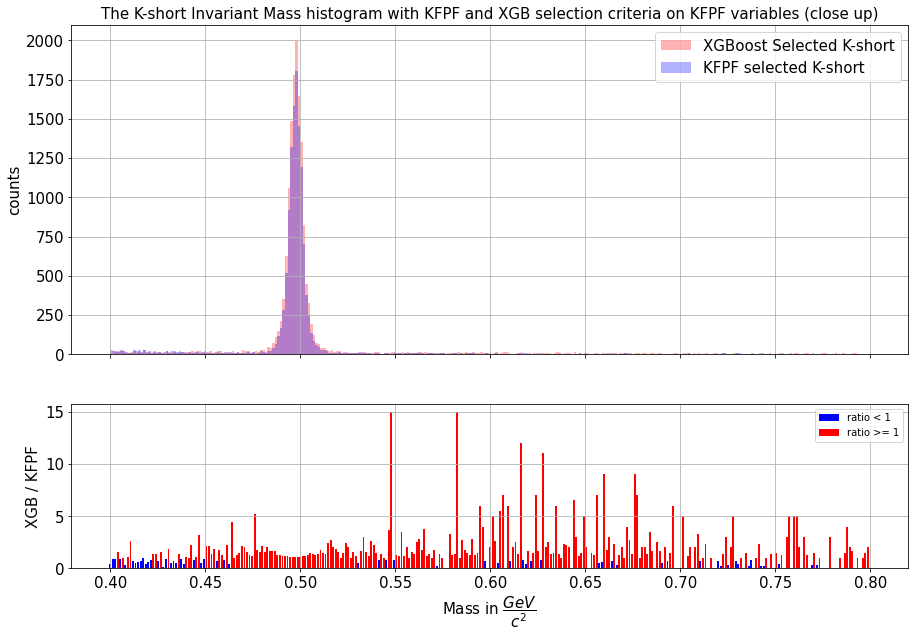

In [44]:
from matplotlib import gridspec

range1= (0.4, 0.8)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3['mass']),bins = 300, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 300, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGBoost Selected K-short','KFPF selected K-short'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The K-short Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables (close up)", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3['mass'],range=(lowerMassCut, upperMassCut), bins=300)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(lowerMassCut, upperMassCut), bins=300)

#ratio checked with division by 0
ratioBlue = [] #ratio smaller than 1
ratioRed = [] # ratio bigger than 1
for i in range(len(ns1)):
    if (ns1[i] != 0):
        ratio = ns[i] / ns1[i]
        if (ratio < 1):
            ratioBlue.append(ratio)
            ratioRed.append(0)
        else:
            ratioBlue.append(0)
            ratioRed.append(ratio)
    else:
        ratioBlue.append(0)
        ratioRed.append(0)
#col = []
# for val in ratio:
#     if val < 1:
#         col.append('blue')
#     else:
#         col.append('red')        
axs[1].bar(bins[:-1],     
        ratioBlue, 
        width=0.001,
        color = 'blue',
        label='ratio < 1')
axs[1].bar(bins[:-1],     
        ratioRed, 
        width=0.001,
        color = 'red',
        label='ratio >= 1')
axs[1].legend( loc='upper right')
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig(directory+'img/xgb2/kaon_inv_mass_comparison_closeup.png')
fig.savefig(directory+'img/xgb2/kaon_inv_mass_comparison_closeup.pdf')

In [45]:
#del x,y,x_test,y_test,x_whole,y_whole,dtest,dtrain,dtest1,df3,df_clean,df_scaled
gc.collect()

81938

# Importing the final predictor to root
We will use the treelite library to transport the final predictor of our model to root

In [46]:
#install treelite 
import treelite
#create an object out of your model, bst in our case
model = treelite.Model.from_xgboost(bst)
#use GCC compiler
toolchain = 'gcc'
#parallel_comp can be changed upto as many processors as one have
model.export_lib(toolchain=toolchain, libpath='./mymodel.so',
                 params={'parallel_comp': 8}, verbose=True)

# Operating system of the target machine
platform = 'unix'
# C compiler to use to compile prediction code on the target machine
toolchain = 'gcc'
# Save the source package as a zip archive named mymodel.zip
# Later, we'll use this package to produce the library mymodel.so.
model.export_srcpkg(platform=platform, toolchain=toolchain,
                    pkgpath='./mymodel.zip', libname='mymodel.so',
                    verbose=True)

[17:11:04] /private/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/pip-install-oxnatwgb/treelite_e3dfb08a68dd4d41abc56837b93249cb/build/temp.macosx-11.1-arm64-3.8/treelite/src/compiler/ast_native.cc:703: Using ASTNativeCompiler
[17:11:04] /private/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/pip-install-oxnatwgb/treelite_e3dfb08a68dd4d41abc56837b93249cb/build/temp.macosx-11.1-arm64-3.8/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 8 translation units.
[17:11:04] /private/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/pip-install-oxnatwgb/treelite_e3dfb08a68dd4d41abc56837b93249cb/build/temp.macosx-11.1-arm64-3.8/treelite/src/c_api/c_api.cc:78: Code generation finished. Writing code to files...
[17:11:04] /private/var/folders/_8/1pnnpyz111s3q4bf02xypbgc0000gn/T/pip-install-oxnatwgb/treelite_e3dfb08a68dd4d41abc56837b93249cb/build/temp.macosx-11.1-arm64-3.8/treelite/src/c_api/c_api.cc:83: Writing file recipe.json...
[17:11:04] /

In [47]:
!unzip mymodel.zip

Archive:  mymodel.zip
replace mymodel/header.h? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [48]:
#Build the source package (using GNU Make or NMake).
%cd mymodel 
!make

!ls

/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library/mymodel
make: `mymodel.so' is up to date.
CBM_ML_Lambda_Library main.c                recipe.json
Makefile              main.o
header.h              mymodel.so


If one wants to transfer this model to a different computer, target machine, then one should follow the following commands in command prompt

In [49]:
sftp john@lxpool.gsi.de
sftp> put mymodel.zip
sftp> quit

SyntaxError: invalid syntax (1897124503.py, line 1)

In [ ]:
ssh john@lxpool.gsi.de
unzip mymodel.zip
cd mymodel
make -j8



The following C++ code can be the applied as a macro on some new data file

In [ ]:
%%writefile test.cpp
#include "TROOT.h"
#include "TFile.h"
#include "TTree.h"
#include "TH1F.h"
#include <vector>
#include "TString.h"
#include "TMath.h"
#include "TH1.h"
#include "TF1.h"
#include "TCanvas.h"

#include <stdio.h>
#include <stdlib.h>
#include "main.c"



void python_to_root(){
  TCanvas* c1 = new TCanvas();
  //c1->Divide(2,1);
  
  //c1->cd(1);
  
  /* Open the root file*/
  TFile *f = new TFile("/gdrive/My Drive/presentations/treelite/10k_events_PFSimplePlainTree.root","UPDATE");
  TTree *t1 = (TTree*)f->Get("PlainTree");
  
  
  Float_t  LambdaCandidates_chi2primneg, LambdaCandidates_chi2primpos, LambdaCandidates_ldl, LambdaCandidates_distance, LambdaCandidates_chi2geo, LambdaCandidates_mass;
  
  t1->SetBranchAddress("LambdaCandidates_chi2primneg",&LambdaCandidates_chi2primneg);
  t1->SetBranchAddress("LambdaCandidates_chi2primpos",&LambdaCandidates_chi2primpos);
  t1->SetBranchAddress("LambdaCandidates_ldl",&LambdaCandidates_ldl);
  t1->SetBranchAddress("LambdaCandidates_distance",&LambdaCandidates_distance);
  t1->SetBranchAddress("LambdaCandidates_chi2geo",&LambdaCandidates_chi2geo);
  t1->SetBranchAddress("LambdaCandidates_mass",&LambdaCandidates_mass);
  
  
  std::vector<float> output{};
  
  const long n_entries = t1->GetEntries();
  output.reserve(n_entries);

  const size_t n_features = 5;
  union Entry input[n_features];
  
  //let's create a new branch which will store the probability returened for each proton-pion pair by our model 
  Float_t probab;
  TBranch *bpt = t1->Branch("probab",&probab,"probabilities");
  t1->SetBranchAddress("probab",&probab);
  
  TH1F *h = new TH1F("h_prob", "This is the #Lambda invariant mass after the cut >0.918080", 300, 1.04, 1.4);
  h->GetXaxis()->SetTitle("[GeV]");
  
  for (long i = 0; i < n_entries; i++)
   {
     t1->GetEntry(i);
    
    input[0].fvalue = LambdaCandidates_chi2primneg;
    input[1].fvalue = LambdaCandidates_chi2primpos;
    input[2].fvalue = LambdaCandidates_ldl;
    input[3].fvalue = LambdaCandidates_distance;
    input[4].fvalue = LambdaCandidates_chi2geo;
    
    output.push_back(predict(input, 0));
    probab= output.at(i);
   
    if(probab > 0.918080){
    h->Fill(LambdaCandidates_mass);}
  }
  
  h->Draw();

  
  
}


In [ ]:
# Installing root
!mkdir -p APPS
!pwd
!cd APPS && wget https://root.cern/download/root_v6.22.00.Linux-ubuntu19-x86_64-gcc9.2.tar.gz 
!cd APPS && tar -xf root_v6.22.00.Linux-ubuntu19-x86_64-gcc9.2.tar.gz